# Experimentando classificação com diferentes tipos de preprocessamento no calculo do LBP

> Utilizando o dataset de toras previamente cortadas

* com diferentes quantidades de pontos para o cálculo do LBP (4 e 8);
  * com diferentes formas de "Binarizar" com OTSU antes de ir para o LBP:
    * maior: pixel com valor maior que o threshold se torna 1;
    * menor: pixel com valor menor que o threshold se torna 0;
    * ambos;

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from zipfile import ZipFile
from matplotlib import pyplot as plt

from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage.feature import local_binary_pattern

# Arquivo local
from img_edit import best_rgb, rgb_to_color

# Parâmetros do local_binary_pattern
METHOD = 'nri_uniform'
RADIUS = 1
N_POINTS = [4, 8]

ZIP_PATH = 'toras_cortadas.zip'
TARGET_NAMES = ['broca', 'fissura', 'musgo', 'quebra']
COLOR_MAP = ['vermelho', 'verde', 'azul']

sns.set_style('darkgrid')

## Varrendo arquivo zip buscando imagens

In [2]:
path_dict = {name: [] for name in TARGET_NAMES}

with ZipFile(ZIP_PATH) as zip_file:
  for path in zip_file.namelist():
    # a pasta de cada amostra é o segundo elemento do split
    folder = path.split('/')[1]
    # Separando amostras por classe
    if ('.JPG' in path) and (folder in TARGET_NAMES):
      path_dict[folder].append(f'./{ZIP_PATH}/{path}')

# Mostrando quantidade de amostras por classe
qtd_amostras_p_classe = []
for target in path_dict:
  n_amostras = len(path_dict[target])
  print(f'{target}: {n_amostras} amostras')

  qtd_amostras_p_classe.append(n_amostras)

N_MIN_DE_AMOSTRAS = min(qtd_amostras_p_classe)

broca: 298 amostras
fissura: 2766 amostras
musgo: 505 amostras
quebra: 679 amostras


## Funções de aplicação do limiar de OTSU

In [3]:
def menor(arr, limiar) -> np.ndarray:
  img_otsu = arr.copy()
  img_otsu[arr<limiar] = 0
  return img_otsu

def maior(arr, limiar) -> np.ndarray:
  img_otsu = arr.copy()
  img_otsu[arr>=limiar] = 1
  return img_otsu

def ambos(arr, limiar) -> np.ndarray:
  return arr >= limiar

## Calculando LBP e gerando arquivos `.csv`


calculando LBP com 4 pontos
classe broca
classe fissura
classe musgo
classe quebra


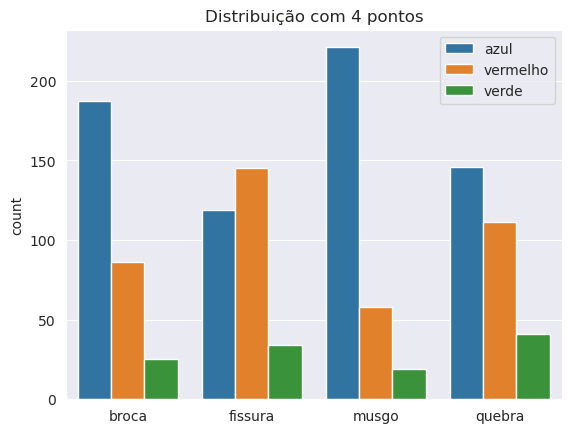


calculando LBP com 8 pontos
classe broca
classe fissura
classe musgo
classe quebra


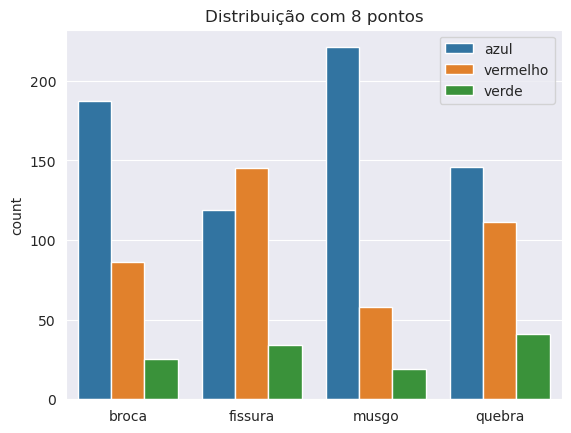

In [4]:
for n_points, n_bins in zip(N_POINTS, [17, 60]):
  print(f'\ncalculando LBP com {n_points} pontos')
  target_list = []
  color_list = []
  func_list = [(ambos, []),
               (menor, []),
               (maior, [])]

  for i, target_name in enumerate(TARGET_NAMES):
    print(f'classe {target_name}')
    # Pegando apenas as N primeiras amostras de cada classe
    path_list_slice = path_dict[target_name][:N_MIN_DE_AMOSTRAS]

    for path in path_list_slice:
      img_name = path.split('/')[-1].lower()

      img = imread(path)
      _, cor = best_rgb(img)
      new_img = rgb_to_color(img, cor)

      # Salvando metadados
      target_list.append(i)
      color_list.append(cor)

      # Gerando arquivos csv com LBP
      img_resolution = new_img.shape[0] * new_img.shape[1]
      for func, amostras in func_list:
        img_otsu = func(new_img, threshold_otsu(new_img))

        lbp_flat = local_binary_pattern(image=img_otsu,
                                        P=n_points,
                                        R=RADIUS,
                                        method=METHOD).flatten()
        
        arr, _ = np.histogram(lbp_flat, bins=range(n_bins), density=False)
        arr = arr / img_resolution

        amostras.append(arr)
  sns.countplot(
    x=[TARGET_NAMES[t] for t in target_list],
    hue=[COLOR_MAP[c] for c in color_list]
    ).set(
      title=f'Distribuição com {n_points} pontos')
  plt.show()

  for func, amostras in func_list:
    data = pd.DataFrame(amostras)
    data['target'] = target_list
    # data['colors'] = color_list
    data.to_csv(f'./csvs/prepro_6-{func.__name__}-P{n_points}.csv', index=False)

## Analisando desempenho com SVM

> Descomente _imports_ caso não tenha executado células superiores

In [5]:
# # importado de células anteriores
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

from sklearnex import patch_sklearn
patch_sklearn() # Deve ser chamada antes dos imports no sklearn

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# TARGET_NAMES = ['broca', 'fissura', 'musgo', 'quebra'] # Já declarado anteriormente

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [6]:
FUNC_NAMES = ['ambos', 'menor', 'maior']

# Gerando 30 sementes "aleatórias" dentro do intervalo [0, 8000)
seed_arr = np.random.randint(8000, size=30)
print(f'seeds: {seed_arr}')

points_dict = {p:{'acuracias':[]} for p in N_POINTS}
for n_points in points_dict:
  X_list = []
  for name in FUNC_NAMES:
    points_dict[n_points][f'cm_{name}'] = []

    data = pd.read_csv(f'./csvs/prepro_6-{name}-P{n_points}.csv')
    target = data.pop('target').values
    X_list.append((data.values, target))

  for rodada, seed in enumerate(seed_arr):
    acc = [0, 0, 0]
    
    for i, (X, y) in enumerate(X_list):
      # separando dados
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

      # Instanciando classificador com padronizador
      clf = make_pipeline(StandardScaler(),
                          SVC(gamma='auto',
                              cache_size=600,
                              random_state=seed)
                          ).fit(
                            X_train,
                            y_train)

      acc[i] = clf.score(X_test, y_test)
      y_pred = clf.predict(X_test)
      points_dict[n_points][f'cm_{FUNC_NAMES[i]}'].append(confusion_matrix(y_test, y_pred, normalize='true'))

    points_dict[n_points]['acuracias'].append(acc)

seeds: [3454  651 6890 5387 2214 7820 1091 7578 6701 5506 4178 4494 7518 5127
 1572 5403 7761 5872 5605 2191 4728 5992  496 3464 1742 1719  975 1418
 6368  380]


       ambos     menor     maior
0   0.578212  0.681564  0.589385
1   0.558659  0.692737  0.606145
2   0.592179  0.678771  0.597765
3   0.583799  0.681564  0.597765
4   0.553073  0.634078  0.600559
5   0.558659  0.662011  0.581006
6   0.555866  0.689944  0.575419
7   0.583799  0.678771  0.547486
8   0.544693  0.678771  0.572626
9   0.555866  0.648045  0.544693
10  0.525140  0.670391  0.547486
11  0.561453  0.678771  0.600559
12  0.583799  0.673184  0.569832
13  0.533520  0.678771  0.553073
14  0.569832  0.673184  0.569832
15  0.581006  0.692737  0.558659
16  0.569832  0.667598  0.564246
17  0.547486  0.701117  0.608939
18  0.578212  0.664804  0.583799
19  0.581006  0.687151  0.581006
20  0.620112  0.734637  0.589385
21  0.567039  0.662011  0.500000
22  0.583799  0.687151  0.569832
23  0.606145  0.709497  0.634078
24  0.597765  0.684358  0.581006
25  0.547486  0.678771  0.536313
26  0.547486  0.723464  0.597765
27  0.539106  0.689944  0.527933
28  0.586592  0.703911  0.600559
29  0.5167

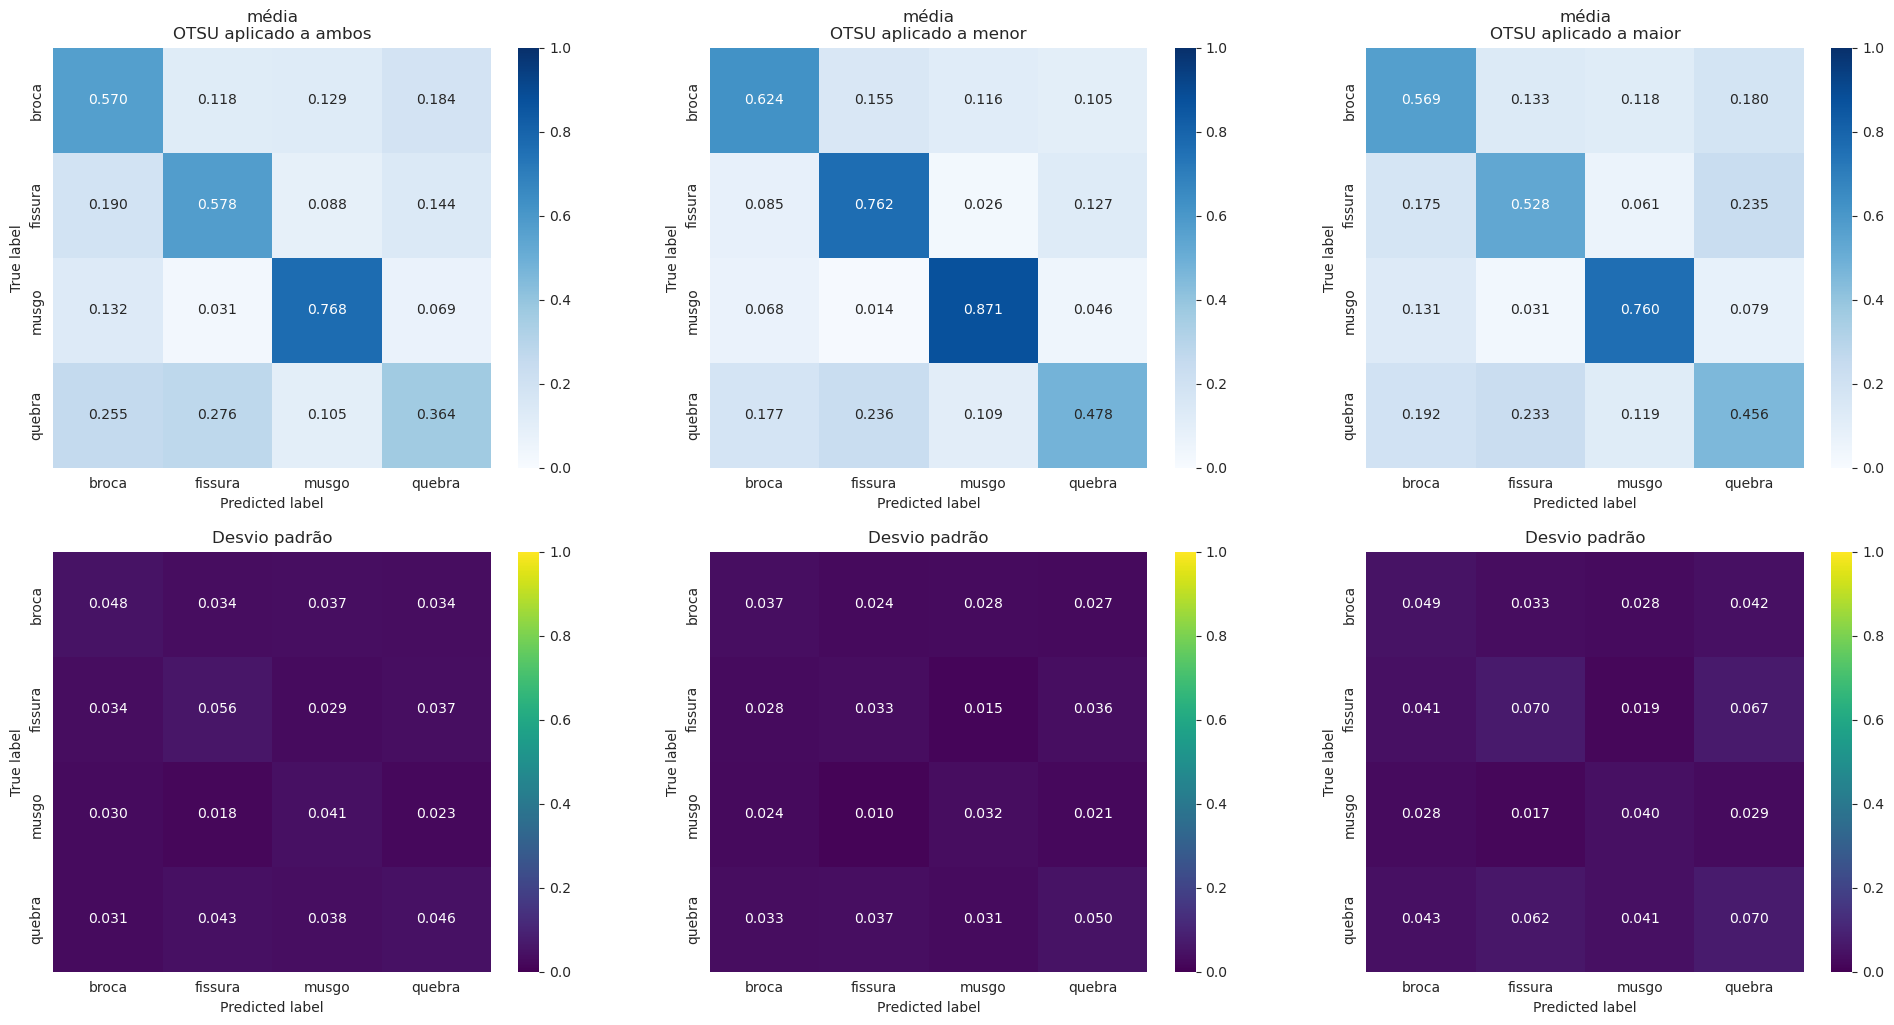

           ambos      menor      maior
count  30.000000  30.000000  30.000000
mean    0.566946   0.681285   0.574860
std     0.023877   0.020817   0.027985
min     0.516760   0.634078   0.500000
25%     0.548883   0.671089   0.558659
50%     0.568436   0.678771   0.578212
75%     0.583799   0.689944   0.597765
max     0.620112   0.734637   0.634078


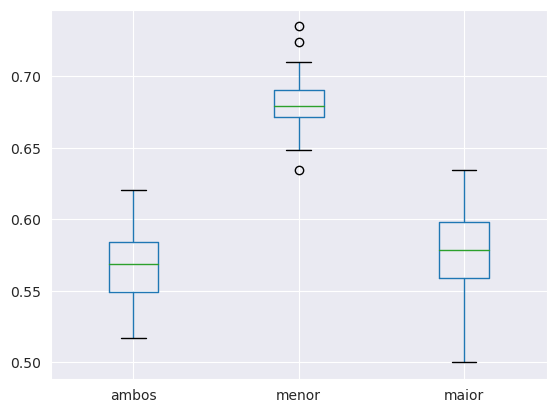

       ambos     menor     maior
0   0.589385  0.715084  0.639665
1   0.561453  0.706704  0.634078
2   0.592179  0.726257  0.648045
3   0.620112  0.726257  0.608939
4   0.567039  0.687151  0.617318
5   0.597765  0.703911  0.622905
6   0.569832  0.720670  0.614525
7   0.614525  0.731844  0.583799
8   0.572626  0.706704  0.628492
9   0.567039  0.692737  0.606145
10  0.547486  0.717877  0.608939
11  0.589385  0.720670  0.625698
12  0.600559  0.701117  0.645251
13  0.519553  0.695531  0.592179
14  0.586592  0.712291  0.645251
15  0.600559  0.709497  0.578212
16  0.575419  0.689944  0.622905
17  0.578212  0.715084  0.678771
18  0.586592  0.729050  0.645251
19  0.578212  0.703911  0.639665
20  0.625698  0.751397  0.664804
21  0.544693  0.701117  0.620112
22  0.603352  0.715084  0.620112
23  0.622905  0.729050  0.664804
24  0.622905  0.729050  0.622905
25  0.564246  0.703911  0.594972
26  0.575419  0.754190  0.631285
27  0.561453  0.720670  0.567039
28  0.592179  0.754190  0.650838
29  0.5586

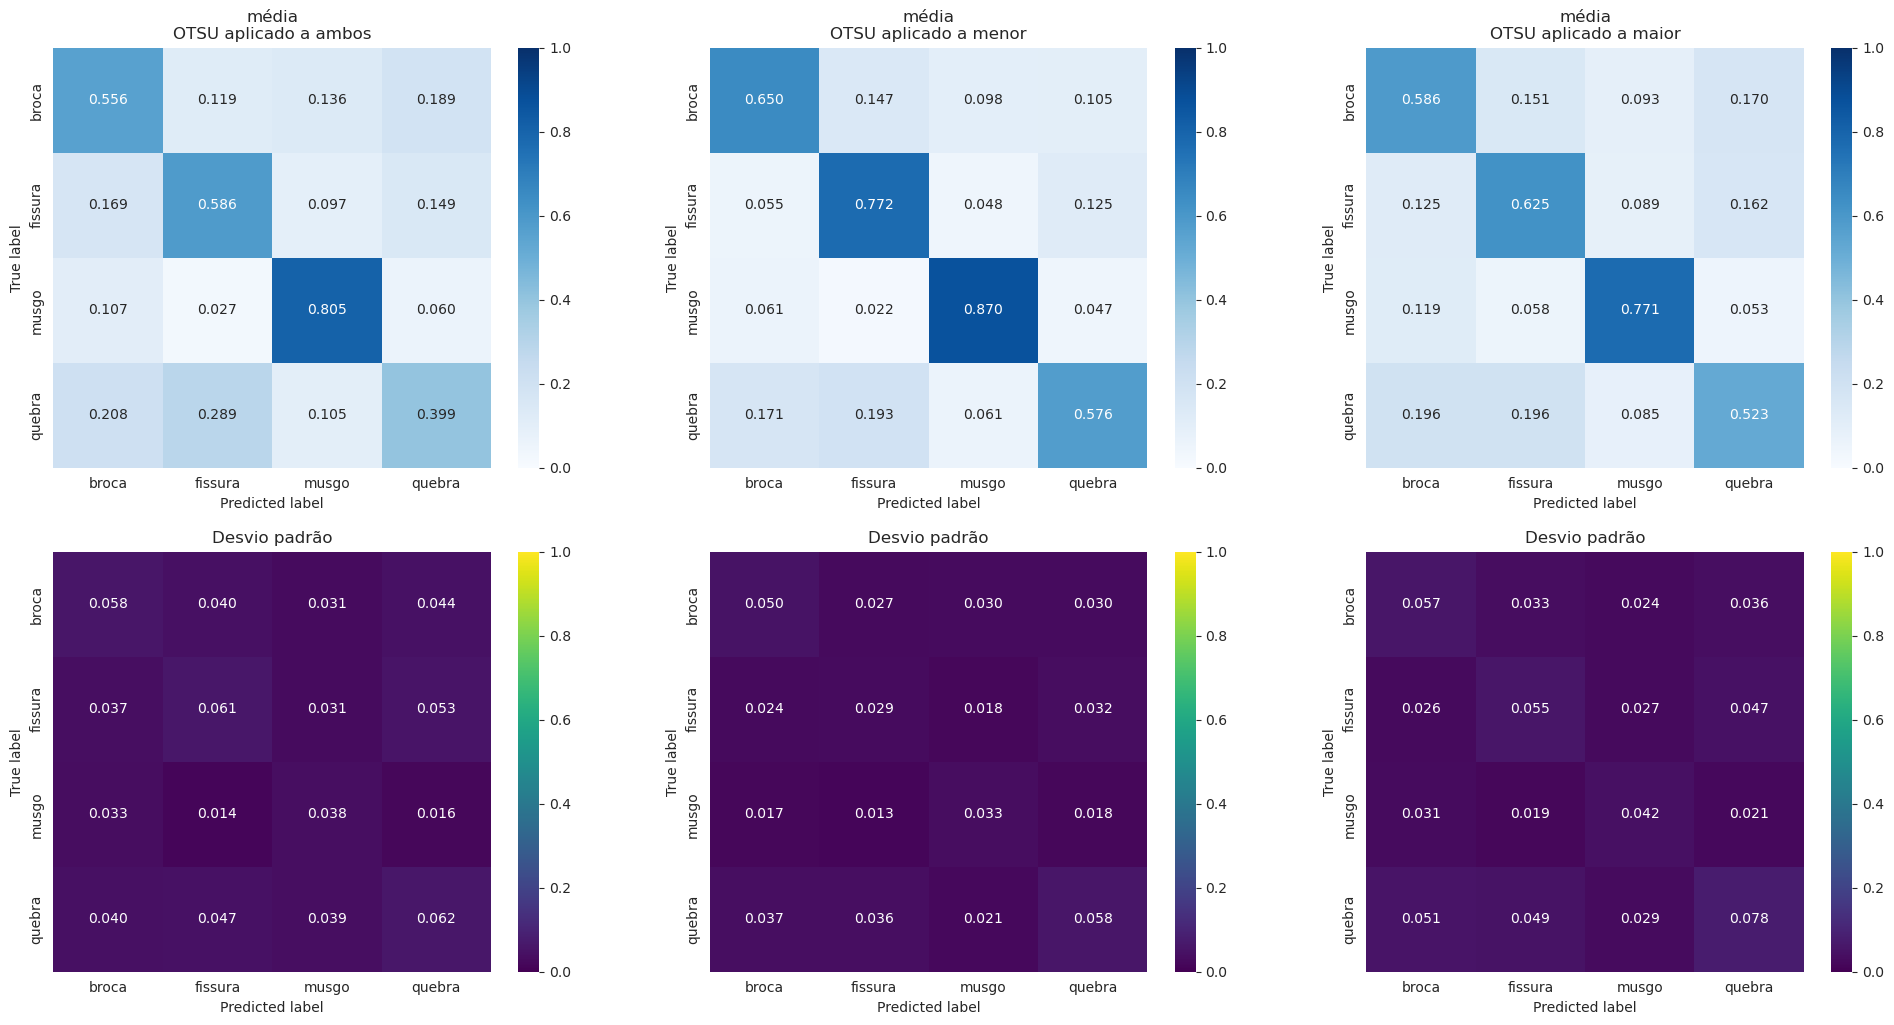

           ambos      menor      maior
count  30.000000  30.000000  30.000000
mean    0.582868   0.714991   0.623836
std     0.025245   0.018709   0.026533
min     0.519553   0.678771   0.567039
25%     0.567039   0.703911   0.608939
50%     0.582402   0.715084   0.622905
75%     0.599860   0.726257   0.643855
max     0.625698   0.754190   0.678771


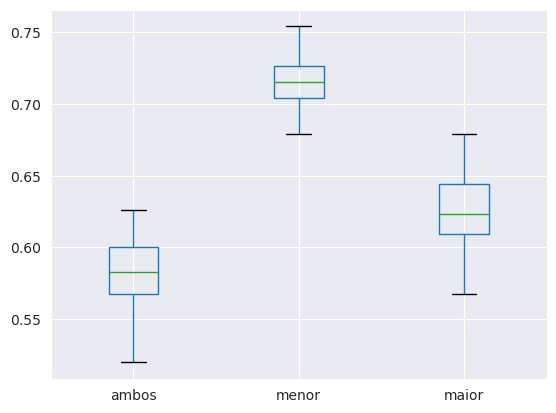

In [9]:
for n_points in points_dict:
  acc_df = pd.DataFrame(data=points_dict[n_points]['acuracias'],
                        columns=FUNC_NAMES)
  print(acc_df)

  print(f'Matrix de confusão a partir do dados do LBP com {n_points} pontos')
  fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))
  for i, name in enumerate(FUNC_NAMES):
    confusion_matrix_mean = np.mean(points_dict[n_points][f'cm_{name}'], axis=0)
    sns.heatmap(
      data=confusion_matrix_mean,
      cmap='Blues',
      vmin=0,
      vmax=1,
      annot=True,
      fmt='.3f',
      mask=confusion_matrix_mean == 0,
      xticklabels=TARGET_NAMES,
      yticklabels=TARGET_NAMES,
      ax=ax[0, i]
      ).set(
          title=f'média\nOTSU aplicado a {name}',
          xlabel='Predicted label',
          ylabel='True label')

    confusion_matrix_std = np.std(points_dict[n_points][f'cm_{name}'], axis=0)
    sns.heatmap(
      data=confusion_matrix_std,
      cmap='viridis',
      vmin=0,
      vmax=1,
      annot=True,
      fmt='.3f',
      mask=confusion_matrix_std == 0,
      xticklabels=TARGET_NAMES,
      yticklabels=TARGET_NAMES,
      ax=ax[1, i]
      ).set(
          title='Desvio padrão',
          xlabel='Predicted label',
          ylabel='True label')
  plt.show()

  print(acc_df.describe())
  acc_df.boxplot()
  plt.show()